In [105]:
import pandas as pd
import pymongo
import config
import database as db
import matplotlib.pyplot as plt
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

In [75]:
def get_market_year(row):
    year = row['Year']
    week = row['Week']
    culture = row['Culture']
    if culture in ['Blé tendre', 'Blé dur']:
        if week >= 36:
            market_year = f"{year}/{year + 1}"
        else:
            market_year = f"{year - 1}/{year}"
    else:
        if 9 <= week <= 49:
            market_year = f"{year - 1}/{year}"
        else:
            market_year = f"{year - 1}/{year}"
    return market_year

def get_market_year_ble(row):
    year = row['Year']
    week = row['Week']
    if week >= 36:
        market_year = f"{year}/{year + 1}"
    else:
        market_year = f"{year - 1}/{year}"
    return market_year

In [76]:
dfMeteo = pd.read_csv('C:/Users/alexl/Dropbox/Alex/aleexv6Corporation/Trading/Meteo/nouvelle_aquitaine_total.csv', parse_dates=['DATE'])
cursorDev = db.get_database_dev_cond_region().find({})
dfCondition = pd.DataFrame(list(cursorDev)).sort_values(by='Date', ascending=True)

In [89]:
dfConditionNA = dfCondition[(dfCondition['Région'] == 'Nouvelle-Aquitaine') & ((dfCondition['Date'].dt.year >= 2015) & (dfCondition['Date'].dt.year < 2024))]
dfConditionNA['Week'] = dfConditionNA['Semaine'].str.extract(r'S(\d+)')[0].astype(int)
dfConditionNA['Year'] = dfConditionNA['Semaine'].str.extract(r'(\d+)-S\d+')[0].astype(int)
dfConditionNA['MarketYear'] = dfConditionNA.apply(get_market_year, axis=1)
dfConditionNA = dfConditionNA[['Date','Culture', 'MarketYear','Très mauvaises','Mauvaises','Assez bonnes', 'Bonnes', 'Très bonnes']]

dfMeteo['TX'] = dfMeteo['TX'].replace(',', '.', regex=True).astype(float)
dfMeteo['TN'] = dfMeteo['TN'].replace(',', '.', regex=True).astype(float)
dfMeteo['RR'] = dfMeteo['RR'].replace(',', '.', regex=True).astype(float)
dfMeteo['DG'] = dfMeteo['DG'].replace(',', '.', regex=True).astype(float)
dfMeteo['Year'] = dfMeteo['DATE'].dt.year
dfMeteo['Week'] = dfMeteo['DATE'].dt.isocalendar().week
dfMeteo['MarketYear'] = dfMeteo.apply(get_market_year_ble, axis=1)
dfMeteo = dfMeteo[['POSTE', 'DEPARTEMENT', 'DATE', 'MarketYear', 'TX', 'TN', 'RR', 'DG']]

dfMeteoMoyenneNA = dfMeteo.groupby('DATE').agg({
    'MarketYear': 'first',
    'TX': 'mean',
    'TN': 'mean',
    'RR': 'mean',
    'DG': 'mean',
})

In [78]:
dfConditionNABleTendre = dfConditionNA[(dfConditionNA['Culture'] == 'Blé tendre')]
dfConditionNABleTendre

,Date,Culture,MarketYear,Très mauvaises,Mauvaises,Assez bonnes,Bonnes,Très bonnes
9670,2015-01-05,Blé tendre,2014/2015,NaN,0.58,0.96,96.83,1.62
9671,2015-01-12,Blé tendre,2014/2015,NaN,0.58,0.96,96.83,1.62
9672,2015-01-19,Blé tendre,2014/2015,NaN,0.58,0.96,96.83,1.62
9673,2015-01-26,Blé tendre,2014/2015,NaN,0.58,6.30,80.94,12.18
9674,2015-02-02,Blé tendre,2014/2015,NaN,0.58,6.30,80.94,12.18
...,...,...,...,...,...,...,...,...
10069,2023-10-30,Blé tendre,2023/2024,NaN,5.83,24.12,70.05,NaN
10070,2023-11-06,Blé tendre,2023/2024,NaN,6.48,27.83,65.68,NaN
10071,2023-11-13,Blé tendre,2023/2024,0.06,9.59,29.54,60.81,NaN
10072,2023-11-20,Blé tendre,2023/2024,0.06,11.07,30.77,58.10,NaN


In [90]:
dfMeteoMoyenneNA

,MarketYear,TX,TN,RR,DG
DATE,,,,,
2015-01-01,2014/2015,6.746296,-5.611656,0.066184,873.842105
2015-01-02,2014/2015,8.511656,-3.049693,1.187923,422.491228
2015-01-03,2014/2015,11.766667,2.825767,4.263285,29.603448
2015-01-04,2014/2015,11.754321,7.997531,0.561836,0.327586
2015-01-05,2014/2015,8.867702,1.425926,0.138350,120.948276
...,...,...,...,...,...
2023-12-27,2023/2024,13.899061,0.335849,0.823005,145.014851
2023-12-28,2023/2024,12.135681,5.670283,1.121698,11.177340
2023-12-29,2023/2024,12.603286,6.845540,1.181221,0.000000


In [96]:
MeteoRRMarketYearCumulative = dfMeteoMoyenneNA.groupby('MarketYear')['RR'].cumsum().reset_index()
MeteoRRMarketYearCumulative = MeteoRRMarketYearCumulative.rename(columns={'DATE':'Date'})
MeteoRRMarketYearCumulative

,Date,RR
0,2015-01-01,0.066184
1,2015-01-02,1.254106
2,2015-01-03,5.517391
3,2015-01-04,6.079227
4,2015-01-05,6.217577
...,...,...
3282,2023-12-27,574.732700
3283,2023-12-28,575.854398
3284,2023-12-29,577.035619
3285,2023-12-30,579.748295


In [116]:
dfConditionNABleTendreMeteo = pd.merge(dfConditionNABleTendre, MeteoRRMarketYearCumulative, on='Date')
dfConditionNABleTendreMeteo.fillna(0, inplace=True)
condition = (dfConditionNABleTendreMeteo['Bonnes'] + dfConditionNABleTendreMeteo['Très bonnes'] + dfConditionNABleTendreMeteo['Assez bonnes'] + dfConditionNABleTendreMeteo['Mauvaises'] + dfConditionNABleTendreMeteo['Très mauvaises']) != 0
dfConditionNABleTendreMeteo = dfConditionNABleTendreMeteo[condition].reset_index(drop=True)
dfConditionNABleTendreMeteo

,Date,Culture,MarketYear,Très mauvaises,Mauvaises,Assez bonnes,Bonnes,Très bonnes,RR
0,2015-01-05,Blé tendre,2014/2015,0.00,0.58,0.96,96.83,1.62,6.217577
1,2015-01-12,Blé tendre,2014/2015,0.00,0.58,0.96,96.83,1.62,17.495354
2,2015-01-19,Blé tendre,2014/2015,0.00,0.58,0.96,96.83,1.62,46.042768
3,2015-01-26,Blé tendre,2014/2015,0.00,0.58,6.30,80.94,12.18,56.670787
4,2015-02-02,Blé tendre,2014/2015,0.00,0.58,6.30,80.94,12.18,114.442388
...,...,...,...,...,...,...,...,...,...
387,2023-10-30,Blé tendre,2023/2024,0.00,5.83,24.12,70.05,0.00,233.833835
388,2023-11-06,Blé tendre,2023/2024,0.00,6.48,27.83,65.68,0.00,335.058363
389,2023-11-13,Blé tendre,2023/2024,0.06,9.59,29.54,60.81,0.00,389.060169
390,2023-11-20,Blé tendre,2023/2024,0.06,11.07,30.77,58.10,0.00,410.754903


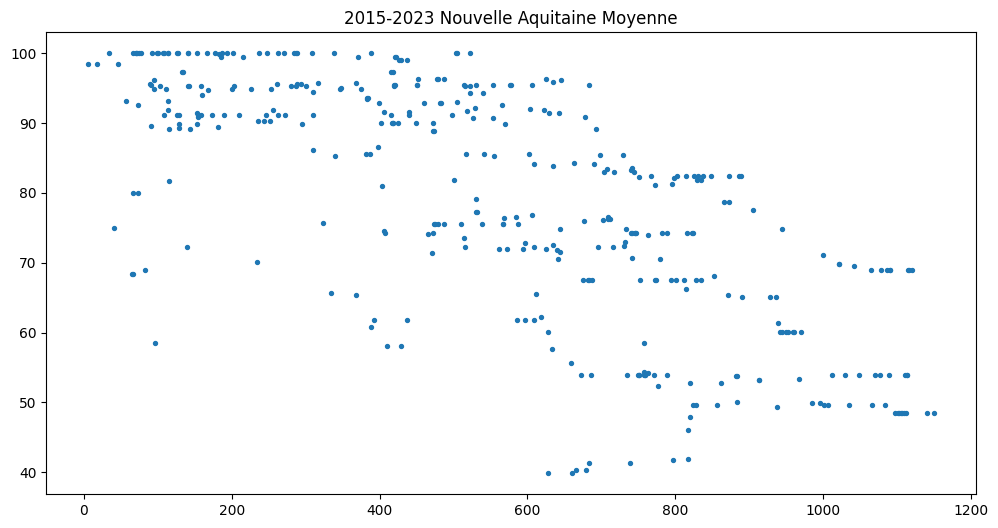

In [112]:
x = dfConditionNABleTendreMeteo['RR'] #cumulative precipation for market year
y = dfConditionNABleTendreMeteo['Bonnes'] + dfConditionNABleTendreMeteo['Très bonnes'] #grain condition Good + Very good
plt.figure(figsize=(12, 6))
plt.scatter(x, y, s=8)
plt.title('2015-2023 Nouvelle Aquitaine Moyenne')
plt.show()

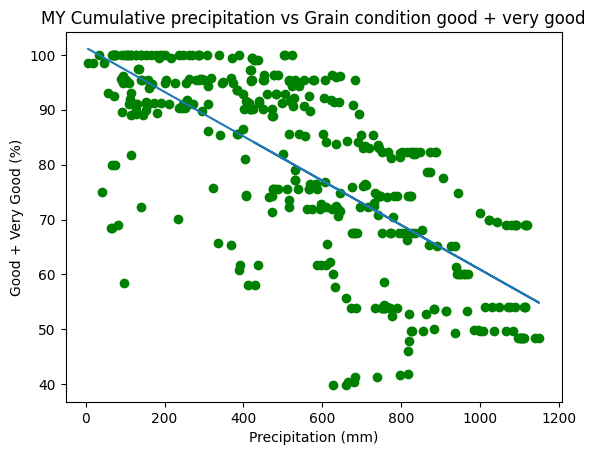

In [121]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.scatter(x, y, color='green')
plt.title('MY Cumulative precipitation vs Grain condition good + very good')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Good + Very Good (%)')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()

In [119]:
print(r_value)

-0.7207269242711638


#PREDICT WITH TODAYS PRECIPITATION VALUES

In [120]:
def y_pred(x):
  return slope * x + intercept

# Predict condition for a cumulative precipitation of x
condition_prediction = y_pred(1177.873957)

print(condition_prediction)

53.68907331995145
